<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Ключевые шаги:**
1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

In [2]:
try:
    taxi =  pd.read_csv('datasets/taxi.csv')
except:
    taxi =  pd.read_csv('/datasets/taxi.csv')

In [3]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Пропусков нет, тип `datetime` необходимо заменить

In [4]:
taxi.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


In [5]:
taxi['datetime'] = pd.to_datetime(taxi['datetime'], format='%Y-%m-%d %H:%M:%S')
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [6]:
taxi.duplicated().sum()

0

Дубликатов нет

In [7]:
#выполним замену индексов для удобства и экономии ресурсов производительных
taxi.index = taxi['datetime']

In [8]:
taxi.drop(columns='datetime',inplace=True)

In [9]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [10]:
#выполним ресемплирование по часу, агрег. функция - суммирование
taxi.sort_index(inplace=True)
taxi = taxi.resample('1H').sum()

In [11]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [12]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Данные подготовлены!

## Анализ

<AxesSubplot:>

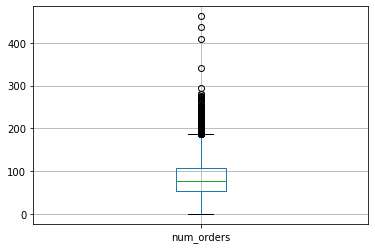

In [13]:
taxi.boxplot()

In [14]:
index = []
Q1 = taxi['num_orders'].describe()['25%']
Q3 = taxi['num_orders'].describe()['75%']
IQR = Q3 - Q1
left = (Q1 - 1.5*IQR)
right = (Q3 + 1.5*IQR)
index = index + (list((taxi[taxi['num_orders']<left]).index)+list((taxi[taxi['num_orders']>right]).index))
index = list(set(index))
print(f'Количество аномалий {len(index)} строк')

Количество аномалий 121 строк


In [15]:
#2,74 процента аномалий
100*len(index)/len(taxi)

2.740036231884058

In [16]:
#taxi.drop(index=index, inplace=True)

Удалять данные в данном случае, при рассмотрении временных рядов мы не будем, чтобы не повлиять на дальнейший ресемплинг

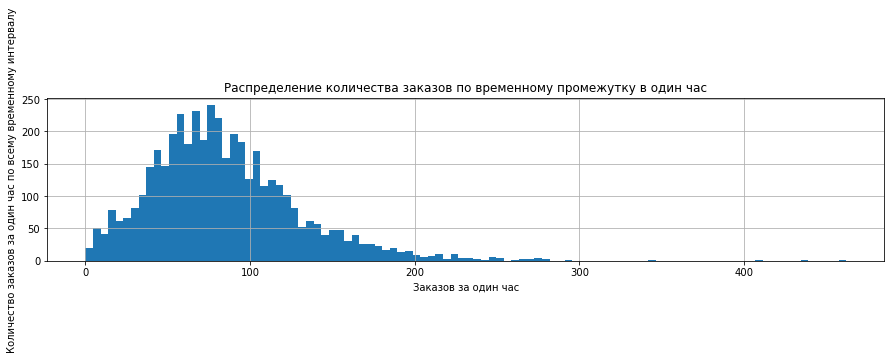

In [17]:
taxi.hist(bins=100, figsize=(15,3))
plt.title('Распределение количества заказов по временному промежутку в один час');
plt.xlabel('Заказов за один час')
plt.ylabel('Количество заказов за один час по всему временному интервалу')
plt.show()

In [18]:
taxi.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


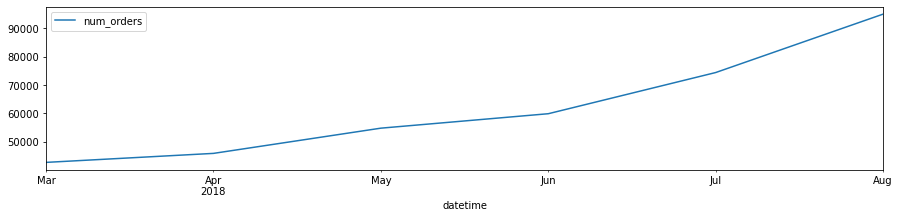

In [19]:
taxi_month = taxi.resample('1M').sum()
taxi_month.plot(figsize=(15,3));

Нагрузка на такси возрастает к августу, что логично, тк летом начинается период отпусков

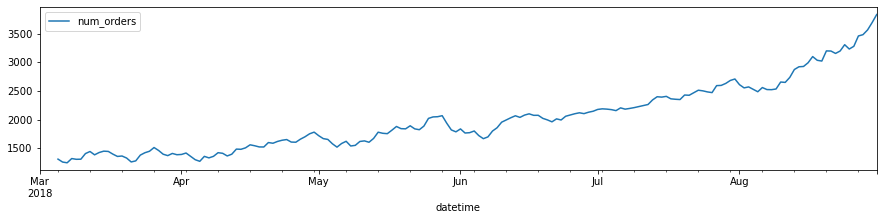

In [20]:
taxi.resample('1D').sum().rolling(5).mean().plot(figsize=(15,3));

Скользящая средняя примерно схожа с ресемплингом по 1 дню. Для ресемплинга по часу - график тяжело различим, но скользящая средняя тоже отражает ту же тенденцию

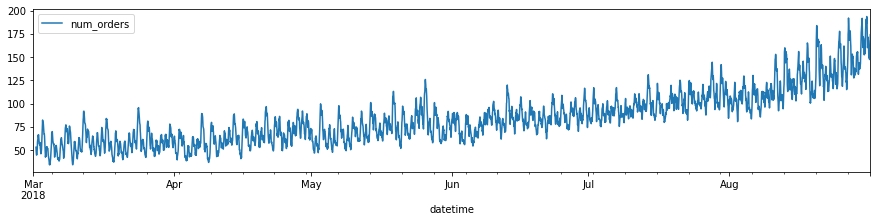

In [21]:
taxi.rolling(15).mean().plot(figsize=(15,3));

In [22]:
#подготовим данные для обучения
#создадим признаки
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(taxi, 25, 5)
taxi.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Обучение

In [23]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

rmse_score = make_scorer(rmse,  greater_is_better=False) 

In [24]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
train = train.dropna()
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

features_train = train.drop(columns='num_orders')
target_train = train['num_orders']

features_test = test.drop(columns='num_orders')
target_test = test['num_orders']

In [25]:
tscv = TimeSeriesSplit(n_splits=5)

In [26]:
reg = LinearRegression()
reg.fit(features_train, target_train)
scores = cross_val_score(reg, features_train, target_train, cv=tscv, scoring=rmse_score, n_jobs=-1)
final_score = scores.mean()
final_score*(-1)

27.009624800356413

In [27]:
lgb = LGBMRegressor(boosting_type='gbdt', random_state=12345, n_jobs=-1)
grid_space={'n_estimators':list(range(10,160,10))}

grid = GridSearchCV(lgb,param_grid=grid_space,cv=tscv,scoring=rmse_score)
lgb_grid = grid.fit(features_train,target_train)

In [28]:
print('Best hyperparameters are: '+str(lgb_grid.best_params_))
print('Best score is: '+str(lgb_grid.best_score_*(-1)))

Best hyperparameters are: {'n_estimators': 60}
Best score is: 25.57499422226967


In [29]:
forest = RandomForestRegressor(random_state=12345)
grid_space={'n_estimators':list(range(50,160,10))}

grid = GridSearchCV(forest,param_grid=grid_space,cv=tscv,scoring=rmse_score, n_jobs=-1)
forest_grid = grid.fit(features_train,target_train)

In [30]:
print('Best hyperparameters are: '+str(forest_grid.best_params_))
print('Best score is: '+str(forest_grid.best_score_*(-1)))

Best hyperparameters are: {'n_estimators': 140}
Best score is: 25.790449036458124


In [31]:
rid = Ridge()
param = {
    'solver':['svd', 'cholesky', 'lsqr', 'sag'],
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
}
grid = GridSearchCV(rid, param, scoring=rmse_score, n_jobs=-1, cv=tscv)
rid_grid = grid.fit(features_train, target_train)

In [32]:
print('Best hyperparameters are: '+str(rid_grid.best_params_))
print('Best score is: '+str(rid_grid.best_score_*(-1)))

Best hyperparameters are: {'alpha': 1e-05, 'solver': 'svd'}
Best score is: 27.009624796485944


Вывод: лучшая модель - lgb_grid , rmse = 25.57

## Тестирование

In [33]:
rmse(target_test, lgb_grid.predict(features_test))

42.74939899906252

In [34]:
#сравним с dummy
dummy = DummyRegressor(strategy="mean") 
dummy.fit(features_train, target_train) 
sqrt(mean_squared_error(target_test, dummy.predict(features_test)))

84.65205585624815

Проверка на "адекватность" - done.

Общий вывод по проделанной работе:
1. Подготовили данные (заменили тип, выполнилил ресемплирование, заменили индексы)
2. Пропусков нет, дубликатов тоже. При анализе также сделали вывод, что к лету вырастает количество заказов такси, что имеет логические подтверждения
3. Сделали признаки для обучения
4. Обучили несколько моделей, изменяя гиперпараметры
5. Выбрали reg модель
6. Rmse на тесте ~ 42.75, проверка на адекватность пройдена